# Week 1

The homework for week 1 consisted of two problems. This notebook contains numerical implementations in the Julia programming language, v1.7.1


# Problem 3.1

Solve the 1D Poisson equation, written in the form $∂^2Φ/∂x^2 = 1$, on a regular grid of 101 points with finite differences and visualize the solution. The model length is 1000 km. Use sparse initialization for the matrix of coefficients {L}, i.e. L = sparse(101,101). Compose a matrix {L} and a right hand side vector {R} (use Eqs. 3.4–3.7 as an example) and obtain the solution vector {S} with a direct solver (in MATLAB with the command S = L\R). Use Φ = 0 as the boundary condition for the two external nodes of the grid (e.g. Fig. 3.3).

In [1]:
# Import necessary packages
using PyPlot
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using AlgebraicMultigrid
using Printf

LoadError: ArgumentError: Package AlgebraicMultigrid [2169fc97-5a83-5252-b627-83903c6c433c] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.


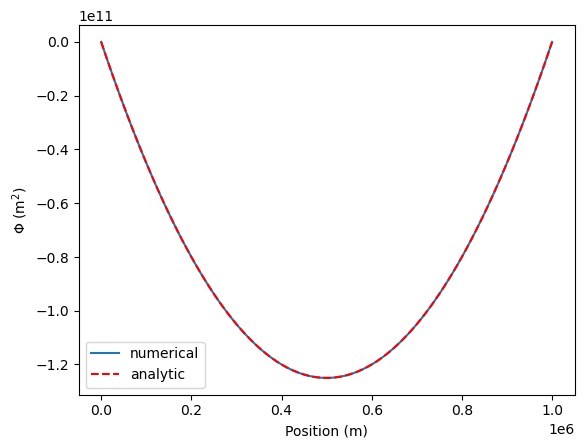

(-1.249999999999995e11, CartesianIndex(51, 1))

In [2]:
width = 1e6 # width in meters
nx = 101
dx = width/(nx-1) # grid spacing

# create vectors to hold indices and values for poisson operator
row_index = zeros(Int64,3*(nx-2)+2)
col_index = zeros(Int64,3*(nx-2)+2)
values = zeros(Float64, 3*(nx-2)+2)
R = zeros(Float64,nx,1)

#row 1
R[1] = 0
ind = 1
values[ind]    = -2/dx^2
row_index[ind] = 1
col_index[ind] = 1
ind += 1
for node in range(2,nx-1)
    # entry that goes in L[i,j-1]
    row_index[ind] = node
    col_index[ind] = node-1
    values[ind] = 1/dx^2
    ind += 1
    row_index[ind] = node
    col_index[ind] = node
    values[ind] = -2/dx^2
    ind += 1
    row_index[ind] = node
    col_index[ind] = node+1
    values[ind] = 1/dx^2
    ind += 1
    R[node] = 1.0
end
# last row
row_index[ind] = nx
col_index[ind] = nx
values[ind] = -2/dx^2
R[nx] = 0.0
# Form a sparse matrix
L = sparse(row_index,col_index,values);
# Use left divide to compute a solution:
solution = L\R;

x = LinRange(0,width,nx)
y_exact = 0.5*x.^2 -0.5*width*x

figure()
plot(LinRange(0,width,nx),solution,label="numerical")
plot(x,y_exact,"r--",label="analytic")
xlabel("Position (m)")
ylabel("\$\\Phi\$ (m\$^2\$)")
legend()
show()

findmin(solution)

# Problem 3.2 - solve the 2D poission equation

$$
\frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = 1
$$

with the Dirichlet boundary condition f=0. 

In [ ]:
# define an indexing function that maps from (i,j) node numbering to an integer index
nx = 10000
ny = 10001
width = 1e3
height = 1.5e3
dx = width/(nx-1)
dy = height/(ny-1)
nn = nx*ny

@inline dof(i::Int64,j::Int64) = (j-1)*ny + i # Gerya 3.22

# pre-allocate arrays to store indices and values
row_index = zeros(Int64,5*nn) # up to 5 nonzeros per row
col_index = zeros(Int64,5*nn)
values = zeros(Float64, 5*nn)
R = zeros(Float64,nn,1)
k=1
for i in 1:ny
    for j in 1:nx
        row = dof(i,j)
        coef_center = -2/dx^2 -2/dy^2
        coef_right = 1/dx^2
        coef_left = 1/dx^2
        coef_up =   1/dy^2
        coef_down = 1/dy^2
        # modify equations for dirichlet boundary condition f=0:
        if i==1 || i == ny || j==1 || j == nx
            row_index[k] = row
            col_index[k] = row
            values[k] = coef_center
            R[row] = coef_center*0.0
            k+=1
        else        
            # center:
            row_index[k] = row
            col_index[k] = dof(i,j)
            values[k] = coef_center
            k+=1
            # left:
            row_index[k] = row
            col_index[k] = dof(i,j-1)
            values[k] = coef_left
            k += 1

            row_index[k] = row
            col_index[k] = dof(i,j+1)
            values[k] = coef_right
            k += 1

            row_index[k] = row
            col_index[k] = dof(i-1,j)
            values[k] = coef_up
            k+=1

            row_index[k] = row
            col_index[k] = dof(i+1,j)
            values[k] = coef_down
            k+=1
            R[row] = 1.
        end
    end
end
@views row_index = row_index[1:(k-1)]
@views col_index = col_index[1:(k-1)]
@views values = values[1:(k-1)]

L = sparse(row_index,col_index,values)
@time solution = L\R
reshape!(solution,ny,nx)

x = LinRange(0,width,nx)
y = LinRange(0,height,ny)
figure()
contourf(x,y,solution,20)
gca().set_aspect("equal")
colorbar(label="\$\\Psi\$ (km\$^2\$)")
xlabel("Position (km)")
ylabel("Position (km)")
show()

figure()
ind = Integer(750/dy)+1
plot(x,solution[ind,:])
title(@sprintf "Transect at %g km depth" y[ind])
xlabel("Position (km)")
ylabel("\$\\Psi\$ (km\$^2\$)")
show()

In [ ]:
# Solve the same problem using gauss-seidel iterations.
theta = 1.5
s = zeros(ny,nx) # boundary conditions are alredy satisfied

norm_store = []
function gauss_seidel(s::Matrix{Float64};rtol=1e-12,max_iter=10000)
    residual = zeros(ny,nx)
    coef_center = -2/dx^2-2/dy^2
    coef_right = 1/dx^2
    coef_left = 1/dx^2
    coef_up = 1/dy^2
    coef_down = 1/dy^2
    iter=1
    while iter < max_iter
        for j in 2:(nx-1)
            for i in 2:(ny-1)
                # in Gauss-Seidel iterations, the solution (s) is updated within each iteration.
                # note that the 1.0 is the (uniform) value of the right hand side, hard-coded for speed.
                residual[i,j] = 1.0 - coef_left*s[i,j-1] - coef_right*s[i,j+1] - coef_up*s[i-1,j] - coef_down*s[i+1,j] - coef_center*s[i,j]
                s[i,j] = s[i,j] + theta*residual[i,j]/coef_center
            end
        end
        iter += 1
        residual_norm = norm(residual)
        append!(norm_store,residual_norm)
        if norm(residual)/norm(s) < rtol # relative tolerance
            break
        end
    end
    return s
end

@time sgs = gauss_seidel(s)

figure()
plot(norm_store)
gca().set_yscale("log")
ylabel("residual 2-norm")
xlabel("Iteration number")
show()

figure()
pcolor(x,y,sgs)
title("Gauss-Seidel Solution")
gca().set_aspect("equal")
colorbar()
show()


figure()
pcolor(x,y,sgs-solution)
gca().set_aspect("equal")
colorbar()
title("Difference between Gauss-Seidel and Direct Solution")
show()

# Playtime

The cells below aren't part of the assigned homework. Because the Gauss-Seidel smoother converges so slowly, I decided to try other iterative methods that are part of IterativeSolvers package in Julia. GMRES converges very slowly as well. By preconditioning GMRES with an algebraic multigrid smoother, I am able to get much more rapid convergence (no surprise here). Note that this code is slower for small problem sizes, but for larger problems (e.g. millions of unknowns), this becomes faster than the direct solver.

In [ ]:
# Attempt a faster solution using GMRES preconditioned with algebraic multigrid
function solve_gmres(L,R)
    ml = ruge_stuben(L);
    p = aspreconditioner(ml);
    return gmres(L, R; Pl=p, restart = 200)
end
    
@time s = solve_gmres(L,R);

In [ ]:
# Plot the solution.
figure()
pcolor(x,y,reshape(s,ny,nx))
gca().set_aspect("equal")
colorbar()
show()